In [1]:
import requests
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')


In [2]:
# USDA API Key
api_key = 'iV7KukQkWfx10au4B794Qc68RL1eBiyPIJkPalm8'

# API Configuration
USDA_URL = 'https://api.nal.usda.gov/fdc/v1/foods/search'
headers = {'Content-Type': 'application/json'}


In [3]:
def get_food_data(food_item, dietary_type='all'):
    # Fetch food data from USDA API
    params = {
        'query': food_item,
        'api_key': api_key,
        'pageSize': 10
    }
    response = requests.get(USDA_URL, params=params, headers=headers)

    if response.status_code == 200:
        return response.json()['foods']
    else:
        print(f"Error fetching data for {food_item}: {response.status_code}")
        return None

def extract_nutrients(food_data):
    # Extract specific nutrients for each food item
    nutrient_values = {
        'food_name': food_data['description'],
        'calories': None,
        'protein': None,
        'carbs': None,
        'fiber': None,
        'fat': None
    }

    for nutrient in food_data.get('foodNutrients', []):
        nutrient_id = nutrient['nutrientId']
        amount = nutrient['value']

        if nutrient_id == 1008:  # Energy (kcal)
            nutrient_values['calories'] = amount
        elif nutrient_id == 1003:  # Protein
            nutrient_values['protein'] = amount
        elif nutrient_id == 1005:  # Carbohydrates
            nutrient_values['carbs'] = amount
        elif nutrient_id == 1079:  # Fiber
            nutrient_values['fiber'] = amount
        elif nutrient_id == 1004:  # Total Fat
            nutrient_values['fat'] = amount

    return nutrient_values


In [4]:
def calculate_caloric_needs(age, weight, height, gender, activity_level):
    # Mifflin-St Jeor Equation for BMR
    if gender == 'male':
        bmr = 10 * weight + 6.25 * height - 5 * age + 5
    else:
        bmr = 10 * weight + 6.25 * height - 5 * age - 161

    # Total Daily Energy Expenditure (TDEE)
    if activity_level == 'sedentary':
        tdee = bmr * 1.2
    elif activity_level == 'light':
        tdee = bmr * 1.375
    elif activity_level == 'moderate':
        tdee = bmr * 1.55
    elif activity_level == 'active':
        tdee = bmr * 1.725
    else:
        tdee = bmr * 1.9  # very active

    return tdee


In [5]:
def get_user_input():
    print("Please provide the following information:")
    age = int(input("Age: "))
    weight = float(input("Weight (kg): "))
    height = float(input("Height (cm): "))
    gender = input("Gender (male/female): ").lower()
    activity_level = input("Activity Level (sedentary, light, moderate, active, very active): ").lower()
    dietary_type = input("Dietary Type (vegan, vegetarian, non-vegetarian): ").lower()

    return age, weight, height, gender, activity_level, dietary_type


In [6]:
def recommend_foods(dietary_type, max_foods=11):
    """
    Recommend a set number of unique foods based on dietary type.
    """
    if dietary_type == 'vegan':
        food_list = ['tofu', 'lentils', 'quinoa', 'chickpeas', 'spinach', 'kale', 'almonds', 'avocado']
    elif dietary_type == 'vegetarian':
        food_list = ['yogurt', 'eggs', 'beans', 'broccoli', 'milk', 'cheese', 'paneer', 'oats', 'peanut butter']
    else:  # non-vegetarian
        food_list = ['chicken breast', 'salmon', 'eggs', 'turkey', 'beef', 'cod', 'shrimp', 'tuna', 'pork loin']

    # Shuffle the list to get random foods, then limit to 6-11 unique items
    np.random.shuffle(food_list)
    return food_list[:np.random.randint(6, max_foods + 1)]


In [7]:
def visualize_nutrient_data(nutrient_df):
    # Create a barplot for the top foods
    nutrient_df.set_index('food_name', inplace=True)
    nutrient_df[['calories', 'protein', 'carbs', 'fiber', 'fat']].plot(kind='bar', figsize=(10,6))
    plt.title('Nutritional Breakdown of Recommended Foods')
    plt.ylabel('Nutrient Value (per 100g)')
    plt.xticks(rotation=45)
    plt.show()

def show_nutrient_table(nutrient_df):
    from IPython.display import display
    display(nutrient_df[['food_name', 'calories', 'protein', 'carbs', 'fiber', 'fat']])


Please provide the following information:


Age:  19
Weight (kg):  76
Height (cm):  190
Gender (male/female):  male
Activity Level (sedentary, light, moderate, active, very active):  moderate
Dietary Type (vegan, vegetarian, non-vegetarian):  non-vegetarian



You need approximately 2879.12 calories per day.



,food_name,calories,protein,carbs,fiber,fat
0,TURKEY,81.0,9.75,6.78,1.3,1.27
1,TUNA,94.0,5.66,10.40,0.9,3.77
2,COD,100.0,12.40,5.29,0.6,2.94
3,EGGS,525.0,7.50,60.00,2.5,27.50
4,"Pork, loin, boneless, raw",NaN,21.10,0.00,NaN,9.47
5,SALMON,139.0,15.20,2.65,0.7,7.95
6,BEEF,125.0,19.60,0.00,0.0,6.25
7,SHRIMP,47.0,11.80,0.00,0.0,0.00
8,CHICKEN BREAST,165.0,20.40,1.06,0.0,8.10


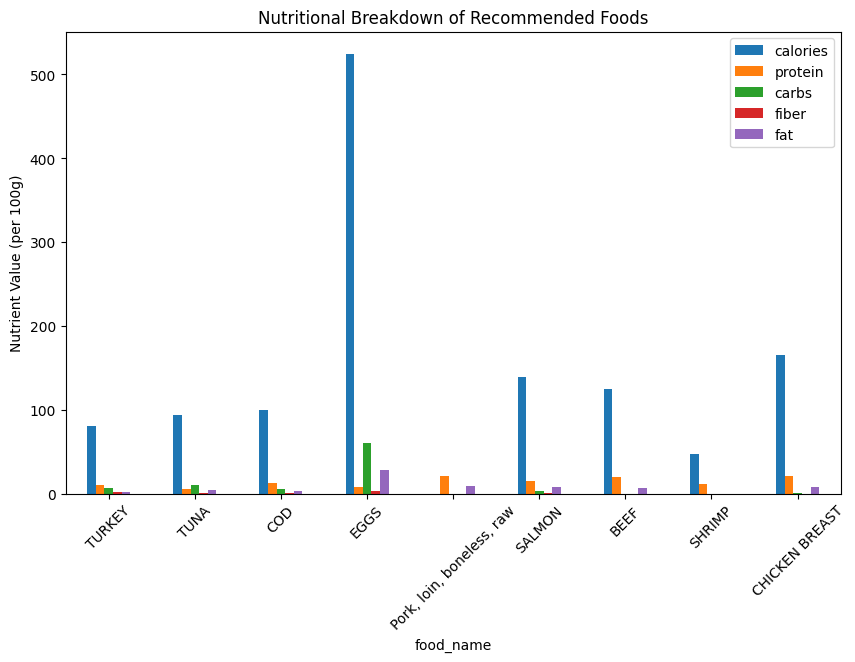

In [8]:
def main():
    # Get user input
    age, weight, height, gender, activity_level, dietary_type = get_user_input()

    # Calculate daily caloric needs
    daily_calories = calculate_caloric_needs(age, weight, height, gender, activity_level)
    print(f"\nYou need approximately {daily_calories:.2f} calories per day.\n")

    # Recommend food based on dietary type, with a limit on the number of foods
    food_list = recommend_foods(dietary_type)

    # Fetch food data and extract nutrients
    nutrient_data = []
    for food in food_list:
        food_data = get_food_data(food, dietary_type)
        if food_data:
            # Only take the first item to avoid duplicates
            nutrient_data.append(extract_nutrients(food_data[0]))

    # Convert to DataFrame
    nutrient_df = pd.DataFrame(nutrient_data)

    # Display the recommended food items and their nutrients
    show_nutrient_table(nutrient_df)

    # Visualize the nutritional breakdown
    visualize_nutrient_data(nutrient_df)

# Run the main function
main()
